<p> Run a simulation corresponding to Trajkovic (1990) experiment</p>
<p> Load .csv dataset of approximate empirical data and compare </p>
<p> Note that $\eta =A \bar{p}/\rho$ is the term in the conservation law;
$H = \eta/{g A}$ is the pressure head in meters<p>

In [1]:
import sys
sys.path.append("..")
from allthethings import PyNetwork, PyPipe_ps
from allthethings import PyBC_opt_dh
import numpy as np
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
#input files: we run two simulations
#30 seconds with gate closed (reflect=1 BC at x=L)
#then start a new simulation with ICs from end of first run
#now with orifice outflow with gate height = e0

fi = "../indata/trajkovic1.inp"
fc = "../indata/trajkovic.config"
fc2 = "../indata/trajkovic2.config"
mtype = 1
n1 = PyNetwork(fi,fc,mtype)
M = n1.M # Number of time steps
T1 =n1.T # Simulation Time 
dt = T1/M 
q = n1.q(0)
A0 = q[0]
Q0 = q[n1.Ns[0]+1]
e0 = 0.008 #choices are 0.008 or 0.015


In [3]:
#run for 30 seconds with gate closed at x=L
n1 = PyNetwork(fi,fc,mtype)
n1.runForwardProblem(dt)
q = n1.q(0)
h = n1.getHofA(0)
qhist = n1.qhist(0)
#assuming 8.1 m stretch of pipe
#n5 = int(5.7/8.1*200)#original measure
n5 = int(5.6/8.1*n1.Ns)-1 
n7 = int(7.6/8.1*n1.Ns)-1
N = n1.Ns[0]
dx = n1.Ls[0]/N
g = 9.8
a = n1.a[0]
Af = (n1.Ds[0]**2)/4.*pi
P71 = n1.pressureTimeSeries(0,n7) 
P51 = n1.pressureTimeSeries(0,n5)
print "A(t=0)) = %f, Q(t=0) = %f"%(A0,Q0)
print "pressure wave speed a= %f, slot width Ts=  %f"%(n1.a[0], g*Af/(a**2))

A(t=0)) = 0.000668, Q(t=0) = 0.001300
pressure wave speed a= 8.770000, slot width Ts=  0.001001


In [4]:
#partially close gate and run for 20 more seconds
n2 = PyNetwork(fi, fc2, mtype)
M2 = n2.M
b0= e0*np.ones(M+1)
n2.setbVal(1,b0);
n2.setIC(0,q[0:N],q[N:])
n2.runForwardProblem(dt)
qhist2 = n2.qhist(0)
#get pressure data for this run
P52 = n2.pressureTimeSeries(0,n5)
P72 = n2.pressureTimeSeries(0,n7)
#stitch together full time series
pnew7 = np.concatenate((P71,P72),axis =0)
pnew5 = np.concatenate((P51,P52),axis =0)



In [5]:
#import Trajkovic data
import csv
fname5='../indata/trajkovic_data/trajkovicp%de0_%1.3f.txt'% (5,e0)
fname7 = '../indata/trajkovic_data/trajkovicp%de0_%1.3f.txt'% (7,e0)
t5 =[]
p5 = []
t7 =[]
p7 = []
c5 = csv.reader(open(fname5,'rb'))
c7 = csv.reader(open(fname7,'rb'))

for line in c5:
    t5.append(float(line[0]))
    p5.append(float(line[1]))
for line in c7:
    t7.append(float(line[0]))
    p7.append(float(line[1]))


In [6]:
#import plotting tools and plot
#from matplotlib import rc
#rc('text', usetex=True)    #for tex rendering. 
#rc('font', **{'family':'serif', 'serif':['Computer Modern Roman'], 
                                #'monospace': ['Computer Modern Typewriter'], 'size'   : 16})
#rc('font', family='serif')     #for pretty font 

#make vector of time steps
M2 = n2.M
T2 = n2.T
T1 = n1.T
t1 = linspace(0,T1, M+1)
t2 = linspace(T1,T1+T2,M2+1)
t = np.concatenate((t1,t2))



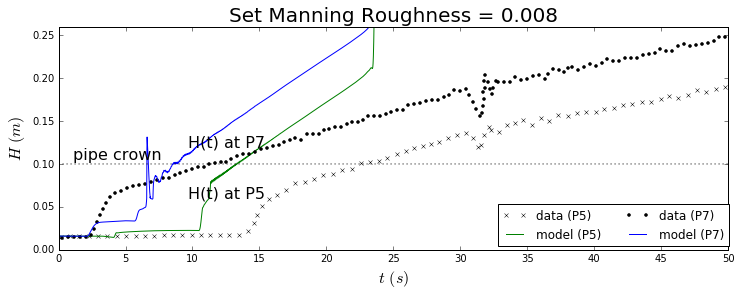

In [7]:
#plot everything
fig, ax = plt.subplots(figsize=(12,4))
ax.set_xlim(0,50)
ax.set_ylim(0,.26)
ax.set_xticks(np.linspace(0,50,11))
ax.set_yticks(np.linspace(0,0.25,6))
sp =10#spacing in data (so you can see both time series)
#account for underlying pipe elevation
z0 = float(n1.Ns[0]-n7)/n1.Ns[0]*.027*n1.Ls[0]-0.005
#put it together
ax.plot(t5[0::sp],p5[0::sp],'kx', ms=4,)
ax.plot(t,pnew5+z0,'g',lw=1)
ax.plot(t7[0::sp],p7[0::sp],'ko', ms=3)
ax.plot(t,pnew7+z0, 'b', lw = 1)
#ax.grid(True)
ax.set_ylabel(r'$H$ $(m)$',size = 16)
ax.set_xlabel(r'$t$ $(s)$',size = 16)
legend(["data (P5)" ,"model (P5)","data (P7)" ,"model (P7)"], loc = 'lower right',bbox_to_anchor=(1.01,-.01), ncol = 2)
ax.plot(t,.1*np.ones(size(t)), 'k:')
plt.title('Set Manning Roughness = 0.008',size=20)
plt.annotate(
    r"H(t) at P7", xy=(9, 0.12), xycoords='data',
    xytext=(9, 0.12), textcoords='offset points',size = 16)
plt.annotate(
    r"H(t) at P5", xy=(9, 0.06), xycoords='data',
    xytext=(9, 0.06), textcoords='offset points',size = 16)
#plt.annotate(
#    r"$e_0$=%.3f"%e0, xy=(1, 0.24), xycoords='data',
#    xytext=(1, 0.24), textcoords='offset points')
plt.annotate(
    r"pipe crown", xy=(1, 0.105), xycoords='data',
    xytext=(1, 0.105), textcoords='offset points',size = 16)
#savefig( "../exampledatae0_%03.0f.eps"%(e0*1000), format='eps')
#savefig('/home/xin/pipes/examples/output_data/real_Mn_for_Trajkovic.png', bbox_inches='tight')